In [3]:
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np

IMG_DIR = pathlib.Path("images/")

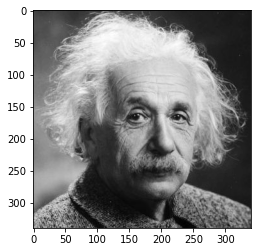

In [6]:
img = cv2.imread(str(IMG_DIR / "Albert_Einstein.jpg"), flags=cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")
plt.show()

In [9]:
# Rotation matrix example.
theta = -45
cos_theta = np.cos(np.deg2rad(theta))
sin_theta = np.sin(np.deg2rad(theta))
rot = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
rot

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

In [10]:
# Albert Einstein image max coordinates.
rmax, cmax = img.shape
coords = np.array([[0, 0], [0, cmax - 1], [rmax - 1, 0], [rmax - 1, cmax - 1]])
coords

array([[  0,   0],
       [  0, 339],
       [339,   0],
       [339, 339]])

In [13]:
coords_rot = rot @ coords.T
mins = coords_rot.min(axis=1)
maxs = coords_rot.max(axis=1)
mins.round(0), maxs.round(0)

(array([   0., -240.]), array([479., 240.]))

In [14]:
min_row, max_row = int(np.floor(mins[0])), int(np.ceil(maxs[0]))
min_col, max_col = int(np.floor(mins[1])), int(np.ceil(maxs[1]))

In [16]:
# Albert Einstein image. Max coordinates after rotation.
height = max_row - min_row + 1
width = max_col - min_col + 1

new_img = np.zeros((height, width), dtype=np.uint8)
new_img.shape

(481, 481)

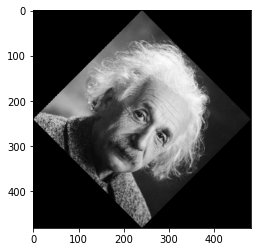

In [18]:
# Rotation with nearest interpolation.
rot_inv = np.linalg.inv(rot)

for new_i in range(min_row, max_row):
    for new_j in range(min_col, max_col):
        new_point = np.array([new_i, new_j])
        point = rot_inv @ new_point
        i, j = point
        if 0 <= i < rmax and 0 <= j < cmax:
            new_img[new_i - min_row, new_j - min_col] = img[int(i), int(j)]

plt.imshow(new_img, cmap="gray")
plt.show()

### Transformations

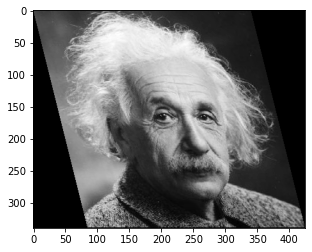

In [19]:
def rotation(angle):
    sina = np.sin(np.deg2rad(angle))
    cosa = np.cos(np.deg2rad(angle))
    return np.array([[cosa, -sina], [sina, cosa]])


def reflection(direction):
    if direction == "x":
        return np.array([[1, 0], [0, -1]])
    if direction == "y":
        return np.array([[-1, 0], [0, 1]])
    if direction == "xy":
        return np.array([[-1, 0], [0, -1]])


def shear(factor, direction):
    if direction == "x":
        return np.array([[1, 0], [factor, 1]])
    if direction == "y":
        return np.array([[1, factor], [0, 1]])


def get_extends(transform, img):
    rmax, cmax = img.shape
    coords = np.array([[0, 0], [0, cmax - 1], [rmax - 1, 0], [rmax - 1, cmax - 1]])
    coords_transform = transform @ coords.T
    mins = coords_transform.min(axis=1)
    maxs = coords_transform.max(axis=1)
    min_row, max_row = int(np.floor(mins[0])), int(np.ceil(maxs[0]))
    min_col, max_col = int(np.floor(mins[1])), int(np.ceil(maxs[1]))
    height = max_row - min_row + 1
    width = max_col - min_col + 1
    return min_row, max_row, min_col, max_col, height, width


def apply_transform(transform, img):
    transform_inv = np.linalg.inv(transform)
    min_row, max_row, min_col, max_col, height, width = get_extends(transform, img)
    new_img = np.zeros((height, width), dtype=np.uint8)

    for new_i in range(min_row, max_row):
        for new_j in range(min_col, max_col):
            i, j = transform_inv @ np.array([new_i, new_j])
            if 0 <= i < img.shape[0] and 0 <= j < img.shape[1]:
                new_img[new_i - min_row, new_j - min_col] = img[int(i), int(j)]

    return new_img


plt.imshow(apply_transform(shear(0.25, "x"), img), cmap="gray")
plt.show()

### Affine Transformations

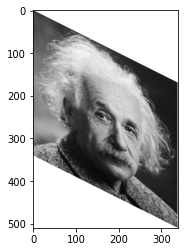

In [21]:
def rotation_affine(angle):
    sina = np.sin(np.deg2rad(angle))
    cosa = np.cos(np.deg2rad(angle))
    return np.array([[cosa, -sina, 0], [sina, cosa, 0], [0, 0, 1]])


def reflection_affine(direction):
    if direction == "x":
        return np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]])
    if direction == "y":
        return np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])
    if direction == "xy":
        return np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]])


def shear_affine(factor, direction):
    if direction == "x":
        return np.array([[1, 0, 0], [factor, 1, 0], [0, 0, 1]])
    if direction == "y":
        return np.array([[1, factor, 0], [0, 1, 0], [0, 0, 1]])


def get_extends_affine(transform, img):
    rmax, cmax = img.shape
    coords = np.array([[0, 0, 1], [0, cmax - 1, 1], [rmax - 1, 0, 1], [rmax - 1, cmax - 1, 1]])
    coords_transform = transform @ coords.T
    mins = coords_transform.min(axis=1)
    maxs = coords_transform.max(axis=1)
    min_row, max_row = int(np.floor(mins[0])), int(np.ceil(maxs[0]))
    min_col, max_col = int(np.floor(mins[1])), int(np.ceil(maxs[1]))
    height = max_row - min_row + 1
    width = max_col - min_col + 1
    return min_row, max_row, min_col, max_col, height, width


def apply_transform_affine(transform, img):
    transform_inv = np.linalg.inv(transform)
    min_row, max_row, min_col, max_col, height, width = get_extends_affine(transform, img)
    new_img = np.ones((height, width), dtype=np.uint8) * 255

    for new_i in range(min_row, max_row):
        for new_j in range(min_col, max_col):
            i, j, _ = transform_inv @ np.array([new_i, new_j, 1])
            if 0 <= i < img.shape[0] and 0 <= j < img.shape[1]:
                new_img[new_i - min_row, new_j - min_col] = img[int(i), int(j)]

    return new_img


plt.imshow(apply_transform_affine(shear_affine(0.5, "y"), img), cmap="gray")
plt.show()

In [22]:
angle = 45
sina = np.sin(np.deg2rad(angle))
cosa = np.cos(np.deg2rad(angle))
rotate = np.array([[cosa, -sina, 0], [sina, cosa, 0], [0, 0, 1]])
translate = np.array([[1, 0, -300], [0, 1, -400], [0, 0, 1]])
shear = np.array([[1, 0.5, 0], [0, 1, 0], [0, 0, 1]])
scale = np.array([[1.5, 0, 0], [0, 1.5, 0], [0, 0, 1]])
transform = np.linalg.inv(translate) @ scale @ shear @ rotate @ translate
transform

array([[   1.59099026,   -0.53033009,   34.83495706],
       [   1.06066017,    1.06066017, -342.46212025],
       [   0.        ,    0.        ,    1.        ]])

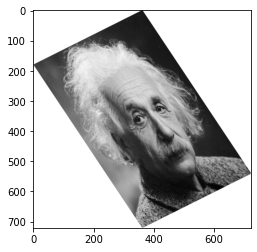

In [23]:
plt.imshow(apply_transform_affine(transform, img), cmap="gray")
plt.show()

In [24]:
# Reflect the image about the line: y = x + 2
angle = -45
sina = np.sin(np.deg2rad(angle))
cosa = np.cos(np.deg2rad(angle))

translate = np.array([[1, 0, -2], [0, 1, 0], [0, 0, 1]])
rotate = np.array([[cosa, -sina, 0], [sina, cosa, 0], [0, 0, 1]])
reflect = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])

transform = np.linalg.inv(translate) @ np.linalg.inv(rotate) @ reflect @ rotate @ translate
transform.round(0)

array([[ 0.,  1.,  2.],
       [ 1.,  0., -2.],
       [ 0.,  0.,  1.]])

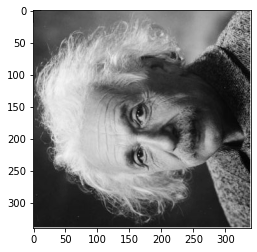

In [25]:
plt.imshow(apply_transform_affine(transform, img), cmap="gray")
plt.show()

### Projective Transformations

In [28]:
def get_extends_projective(transform, img):
    rmax, cmax = img.shape
    coords = np.array([[0, 0, 1], [0, cmax - 1, 1], [rmax - 1, 0, 1], [rmax - 1, cmax - 1, 1]])
    coords_transform = transform @ coords.T
    coords_transform /= coords_transform[2, :]  # Homogenous -> Not Homogenous
    mins = coords_transform.min(axis=1)
    maxs = coords_transform.max(axis=1)
    min_row, max_row = int(np.floor(mins[0])), int(np.ceil(maxs[0]))
    min_col, max_col = int(np.floor(mins[1])), int(np.ceil(maxs[1]))
    height = max_row - min_row + 1
    width = max_col - min_col + 1
    return min_row, max_row, min_col, max_col, height, width


def apply_transform_projective(transform, img):
    transform_inv = np.linalg.inv(transform)
    min_row, max_row, min_col, max_col, height, width = get_extends_projective(transform, img)
    new_img = np.ones((height, width), dtype=np.uint8) * 255

    for new_i in range(min_row, max_row):
        for new_j in range(min_col, max_col):
            i, j, k = transform_inv @ np.array([new_i, new_j, 1])
            i, j = i / k, j / k
            if 0 <= i < img.shape[0] and 0 <= j < img.shape[1]:
                new_img[new_i - min_row, new_j - min_col] = img[int(i), int(j)]

    return new_img

In [29]:
angle = 30
sina = np.sin(np.deg2rad(angle))
cosa = np.cos(np.deg2rad(angle))
R = np.array([[cosa, -sina, 0], [sina, cosa, 0], [0, 0, 1]])
T = np.array([[1, 0, -300], [0, 1, -400], [0, 0, 1]])
Sh = np.array([[1, 0.5, 0], [0, 1, 0], [0, 0, 1]])
S = np.array([[1.3, 0, 0], [0, 0.7, 0], [0, 0, 1]])
A = np.linalg.inv(T) @ S @ Sh @ R @ T

homography = A
homography[2, :] = np.array([0.001, 0.0001, 1])
homography

array([[ 1.45083302e+00, -8.70834875e-02, -1.00416512e+02],
       [ 3.50000000e-01,  6.06217783e-01,  5.25128869e+01],
       [ 1.00000000e-03,  1.00000000e-04,  1.00000000e+00]])

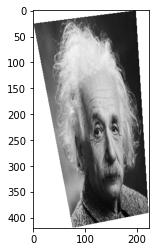

In [30]:
plt.imshow(apply_transform_projective(homography, img), cmap="gray")
plt.show()